In [1]:
import os  
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp  
from scipy import sparse 
from mesohops.dynamics.hops_trajectory import HopsTrajectory as HOPS  
from mesohops.dynamics.eom_hops_ksuper import _permute_aux_by_matrix  
from mesohops.dynamics.bath_corr_functions import bcf_exp, bcf_convert_sdl_to_exp  

/home/fredy/miniconda3/envs/mesohops/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
noise_param = {  

    "SEED": 0,  # This sets the seed for the noise
    "MODEL": "FFT_FILTER", # This sets the noise model to be used
    "TLEN": 500.0, # Units: fs (the total time length of the noise trajectory) 
    "TAU": 1.0, # Units: fs  (the time-step resolution of the noise trajectory
}  

nsite = 2  # The number of pigments in the linear chain we are simulating
e_lambda = 20.0  # The reorganization energy in wavenumbers
gamma = 20.0  # The reorganization timescale in wavenumbers
temp = 295.0  # The temperature in Kelvin
(g_0, w_0) = bcf_convert_sdl_to_exp(e_lambda, gamma, 0.0, temp)  

# Define the L operators |n><n| for each site n  
loperator = np.zeros([2, 2, 2], dtype=np.float64)  
gw_sysbath = []  
lop_list = []  
for i in range(nsite):  
    loperator[i, i, i] = 1.0  
    # Here we apply a short time correction to the correlation function
    # by implementing 2 modes for each pigment: 
    # A Markovian mode and a non-Markovian mode. The Markovian mode is used to cancel the 
    # imaginary part of the non_markovian mode and quickly disappears after short time
    gw_sysbath.append([g_0, w_0])  
    lop_list.append(sp.sparse.coo_matrix(loperator[i]))  
    gw_sysbath.append([-1j * np.imag(g_0), 500.0])  
    lop_list.append(loperator[i])  

In [3]:
# Hamiltonian in wavenumbers
hs = np.zeros([nsite, nsite])  
# Manually set the couplings between pigments. We assume each pigment is isergonic:
# that is, the diagonals of the hamiltonian are all 0.
hs[0, 1] = 15  
hs[1, 0] = 15  
 

# System parameters
sys_param = {  
    "HAMILTONIAN": np.array(hs, dtype=np.complex128),  # the Hamiltonian we constructed
    "GW_SYSBATH": gw_sysbath,  # defines exponential decompositoin of correlation function
    "L_HIER": lop_list,  # list of L operators
    "L_NOISE1": lop_list,  # list of noise params associated with noise1
    "ALPHA_NOISE1": bcf_exp,  # function that calculates correlation function
    "PARAM_NOISE1": gw_sysbath,  # list of noise pararms defining decomposition of noise1
}  


In [4]:
# EOM parameters 
eom_param = {"EQUATION_OF_MOTION": "NORMALIZED NONLINEAR"} # we generally pick normalized nonlinear 
# as it has better convergence properties than the linear eom

# Integration parameters 
integrator_param = {"INTEGRATOR": "RUNGE_KUTTA"}  # We use a Runge-Kutta method for our integrator 

# Initial wave function (in the state basis, we fully populate site 3 and no others)
import time
start = time.time()

psi_0 = np.array([0.0] * nsite)#, dtype=np.complex)  
psi_0[0] = 1.0
# To avoid rounding errors, we normalize the wave function
psi_0 = psi_0 / np.linalg.norm(psi_0)  
t_max = 200.0  # The length of the time axis in fs
t_step = 4.0  # The time resolution in fs
delta = 1e-3 # The bound on derivative error

hops = HOPS(  
    sys_param,  
  noise_param=noise_param, 
  hierarchy_param={"MAXHIER": 10},  
  eom_param=eom_param,  
)  

# Make the HopsTrajectory adaptive, initialize it with the wave function and propagate it to t_max.
hops.make_adaptive(delta/np.sqrt(2), delta/np.sqrt(2))
hops.initialize(psi_0)
hops.propagate(t_max, t_step)

end = time.time()
result = end - start
print(result)

Noise Model initialized with SEED =  0
0 th seed is:  209652396
1 th seed is:  398764591
Integration from  0  to  200.0
22.418381214141846


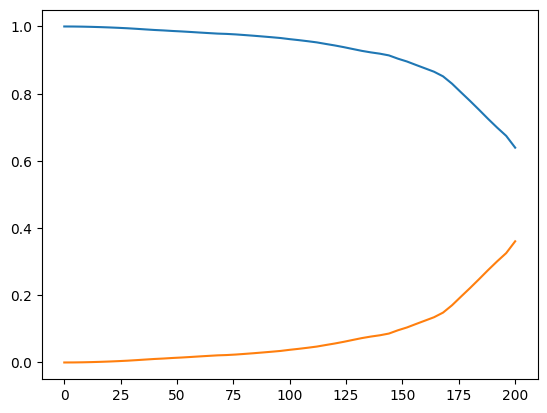

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# gather population and t_axis
pop = np.abs(hops.psi_traj)**2
t_axis = np.arange(0,204,4)
# plot the data
plt.plot(t_axis,pop)
plt.show()

In [6]:
import pandas as pd

# Supposons que pop est un ndarray 2D (n_lignes, 2 colonnes)
# et t_axis une liste de même longueur que le nombre de lignes

# Exemple de données
# pop = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # shape (3, 2)
# t_axis = [0, 1, 2]  # longueur 3

df = pd.DataFrame({
    'time': t_axis,
    'pop_col1': pop[:, 0],  # Première colonne de pop
    'pop_col2': pop[:, 1]   # Deuxième colonne de pop
})


# Sauvegarde
df.to_csv('data.csv', index=False)

In [9]:
11+27+13+12

63